# SickleScope Tutorial: Comprehensive Genetic Variant Analysis

Welcome to the SickleScope tutorial. This notebook will guide you through the complete workflow for analysing genetic variants related to sickle cell disease using the SickleScope Python package.

## Learning Objectives

By the end of this tutorial, you will be able to:
1. **Load and validate genetic variant data**
2. **Perform comprehensive variant classification**
3. **Calculate risk scores using weighted algorithms**
4. **Generate interactive visualisations**
5. **Interpret clinical implications and management recommendations**
6. **Create comprehensive analysis reports**

## Tutorial Overview

- **Level**: Beginner to Intermediate
- **Prerequisites**: Basic Python knowledge and understanding of genetics concepts

---

## 1. Setup and Package Installation

Let's start by importing the necessary libraries and initialising our analysis environment.

In [2]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Libraries imported successfully")
print(f"Python version: {sys.version[:6]}")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully
Python version: 3.13.5
Working directory: C:\Users\Talhah Zubayer\Documents\SickleScope Genomics Project\sickle-scope\notebooks


In [3]:
# Import SickleScope modules
# Adjust the import path based on your installation method
sys.path.append('../')

try:
    from sickle_scope.analyser import SickleAnalyser
    from sickle_scope.visualiser import SickleVisualiser
    print("SickleScope modules imported successfully")
    print("Ready to begin genetic variant analysis!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Make sure you're running this notebook from the notebooks/ directory")
    print("Or install SickleScope with: pip install -e ../")

SickleScope modules imported successfully
Ready to begin genetic variant analysis!


## 2. Understanding the Data Format

Before we begin analysis, let's understand the structure and requirements of genetic variant data for SickleScope.

### Required Data Columns:
- **chromosome**: Chromosome identifier (example: '11', 'chr11')
- **position**: Genomic position (integer)
- **ref_allele**: Reference nucleotide (A, T, G, C)
- **alt_allele**: Alternate nucleotide (A, T, G, C)
- **genotype**: Zygosity information (0/0, 0/1, 1/1)

In [4]:
# Initialise the SickleScope analyser with verbose output
analyser = SickleAnalyser(verbose=True)

print("\n Required Data Columns:")
for i, col in enumerate(analyser.required_columns, 1):
    print(f"  {i}. {col}")

print("\nHBB Gene Region (Chromosome 11):")
print(f"Start position: {analyser.hbb_region['start']:,}")
print(f"End position: {analyser.hbb_region['end']:,}")
print(f"Region size: {analyser.hbb_region['end'] - analyser.hbb_region['start']:,} bp")

print("\nAnalysis Focus:")
print("Pathogenic HBB variants (sickle cell, thalassemia)")
print("Protective modifier variants (BCL11A, HBS1L-MYB)")
print("Risk scoring based on clinical evidence")

Loaded HBB database: 7 pathogenic variants, 5 modifiers
Initialised random_forest predictor
Creating training dataset...
Created training dataset with 73 samples
Severity distribution: {'normal': 50, 'mild': 15, 'severe': 6, 'moderate': 2}
Training random_forest model...
Model training completed:
  Training accuracy: 0.983
  Test accuracy: 0.867
  CV accuracy: 0.920 +/- 0.078
  Top features:
    genotype_type: 0.307
    severity_score: 0.282
    population_frequency: 0.204
ML model trained with 0.920 CV accuracy
SickleAnalyser initialised successfully
Machine learning severity predictor ready

 Required Data Columns:
  1. chromosome
  2. position
  3. ref_allele
  4. alt_allele
  5. genotype

HBB Gene Region (Chromosome 11):
Start position: 5,200,000
End position: 5,280,000
Region size: 80,000 bp

Analysis Focus:
Pathogenic HBB variants (sickle cell, thalassemia)
Protective modifier variants (BCL11A, HBS1L-MYB)
Risk scoring based on clinical evidence


### Sample Data Exploration

Let's examine our sample dataset to understand the expected data format.

In [5]:
# Load sample data to understand the format
sample_data_path = '../tests/sample_data/hbb_variants.csv'

if os.path.exists(sample_data_path):
    sample_df = pd.read_csv(sample_data_path)
    print("Sample Data Structure:")
    print(f"Shape: {sample_df.shape[0]} variants × {sample_df.shape[1]} columns")
    print(f"Columns: {list(sample_df.columns)}")
    
    print("\nFirst few rows:")
    display(sample_df.head())
    
    print("\nData Summary:")
    print(f"Unique chromosomes: {sorted(sample_df['chromosome'].unique().tolist())}")
    print(f"Position range: {sample_df['position'].min():,} - {sample_df['position'].max():,}")
    print(f"Genotypes present: {sorted(sample_df['genotype'].unique())}")
    
else:
    print("Sample data file not found. Let's create example data for demonstration...")
    
    # Create realistic example data based on known HBB variants
    example_data = {
        'chromosome': ['11', '11', '11', '11', '11'],
        'position': [5227002, 5226980, 5226918, 5248000, 5249000],  # Known HBB positions
        'ref_allele': ['T', 'G', 'G', 'C', 'T'],
        'alt_allele': ['A', 'A', 'A', 'G', 'A'],
        'genotype': ['1/1', '0/1', '1/1', '0/1', '0/0']
    }
    sample_df = pd.DataFrame(example_data)
    
    print("Created Example Data:")
    display(sample_df)
    
    # Save example data for analysis
    sample_data_path = 'example_variants.csv'
    sample_df.to_csv(sample_data_path, index=False)
    print(f" Saved example data as: {sample_data_path}")

Sample Data Structure:
Shape: 5 variants × 5 columns
Columns: ['chromosome', 'position', 'ref_allele', 'alt_allele', 'genotype']

First few rows:


,chromosome,position,ref_allele,alt_allele,genotype
0,11,5248232,A,T,1/1
1,11,5248158,G,A,0/1
2,11,5247359,G,A,1/1
3,11,5248000,C,G,0/1
4,11,5249000,T,A,0/0



Data Summary:
Unique chromosomes: [11]
Position range: 5,247,359 - 5,249,000
Genotypes present: ['0/0', '0/1', '1/1']


### Understanding Genotype Formats

SickleScope supports multiple genotype notation formats.

In [6]:
# Demonstrate genotype format understanding
# Slash format (eg: 0/1): Unphased genotypes
# Pipe format (eg: 0|1): Phased genotypes

genotype_guide = {
    '0/0': {'description': 'Homozygous reference (wild-type)', 'impact': 'No risk contribution'},
    '0/1': {'description': 'Heterozygous (carrier)', 'impact': 'Moderate risk (50% of full impact)'},
    '1/1': {'description': 'Homozygous alternate (affected)', 'impact': 'Full risk contribution'},
    '0|0': {'description': 'Phased homozygous reference', 'impact': 'No risk contribution'},
    '0|1': {'description': 'Phased heterozygous', 'impact': 'Moderate risk (50% of full impact)'},
    '1|1': {'description': 'Phased homozygous alternate', 'impact': 'Full risk contribution'}
}

print(" Genotype Format Guide:")
print("=" * 82)
for genotype, info in genotype_guide.items():
    print(f"  {genotype:<4} → {info['description']:<35} | {info['impact']}")

print("\n Genotype Distribution in Sample Data:")
print("=" * 60)
genotype_counts = sample_df['genotype'].value_counts()
total_variants = len(sample_df)

for genotype, count in genotype_counts.items():
    percentage = (count / total_variants) * 100
    description = genotype_guide.get(genotype, {}).get('description', 'Unknown format')
    print(f"  {genotype}: {count} variants ({percentage:.1f}%) - {description}")

 Genotype Format Guide:
  0/0  → Homozygous reference (wild-type)    | No risk contribution
  0/1  → Heterozygous (carrier)              | Moderate risk (50% of full impact)
  1/1  → Homozygous alternate (affected)     | Full risk contribution
  0|0  → Phased homozygous reference         | No risk contribution
  0|1  → Phased heterozygous                 | Moderate risk (50% of full impact)
  1|1  → Phased homozygous alternate         | Full risk contribution

 Genotype Distribution in Sample Data:
  1/1: 2 variants (40.0%) - Homozygous alternate (affected)
  0/1: 2 variants (40.0%) - Heterozygous (carrier)
  0/0: 1 variants (20.0%) - Homozygous reference (wild-type)


## 3. Data Validation and Quality Control

Before analysis, we need to validate our data to ensure it meets SickleScope's requirements.

In [7]:
# Validate the sample data
print("Validating input data...")

is_valid, validation_messages = analyser.validate_input(sample_data_path)

if is_valid:
    print("Data validation PASSED!")
    print("Your data is ready for analysis.")
else:
    print("Data validation FAILED:")
    for i, message in enumerate(validation_messages, 1):
        print(f"  {i}. {message}")
    print("\nPlease fix these issues before proceeding with analysis.")

print("\nData Quality Summary:")
print(f"Total variants: {len(sample_df)}")
print(f"Required columns present: {set(analyser.required_columns).issubset(sample_df.columns)}")
print(f"Unique chromosomes: {sample_df['chromosome'].unique().tolist()}")
print(f"Genotype formats found: {list(sample_df['genotype'].unique())}")
print(f"Position range: {sample_df['position'].min():,} to {sample_df['position'].max():,}")

Validating input data...
Data validation PASSED!
Your data is ready for analysis.

Data Quality Summary:
Total variants: 5
Required columns present: True
Unique chromosomes: [11]
Genotype formats found: ['1/1', '0/1', '0/0']
Position range: 5,247,359 to 5,249,000


## 4. Comprehensive Variant Analysis

Now we will perform the core analysis - classifying variants and assessing their clinical significance using SickleScope's evidence-based algorithms.

In [8]:
# Perform comprehensive variant analysis
print("Starting Comprehensive Variant Analysis...")
print("This may take a few moments...")

# Run the analysis
results = analyser.analyse_file(sample_data_path)

print("\nAnalysis COMPLETED successfully!")
print(f"Results shape: {results.shape[0]} variants × {results.shape[1]} columns")
print(f"New analysis columns added: {results.shape[1] - sample_df.shape[1]}")

print("\nAnalysis Pipeline Steps Completed:")
analysis_steps = [
    "Data standardisation and validation",
    "Variant classification against HBB database",
    "Risk score calculation using weighted algorithms",
    "Clinical severity assessment",
    "Management recommendations generation"
]

for i, step in enumerate(analysis_steps, 1):
    print(f"Step {i}: {step}")

Starting Comprehensive Variant Analysis...
This may take a few moments...
Reading data from: ../tests/sample_data/hbb_variants.csv
Found 5 variants in HBB region
Total variants for analysis: 5
Added ML severity predictions
Identified 0 potentially pathogenic variants

Analysis COMPLETED successfully!
Results shape: 5 variants × 20 columns
New analysis columns added: 15

Analysis Pipeline Steps Completed:
Step 1: Data standardisation and validation
Step 2: Variant classification against HBB database
Step 3: Risk score calculation using weighted algorithms
Step 4: Clinical severity assessment
Step 5: Management recommendations generation


In [9]:
# Examine the analysis results in detail
print("Analysis Results Overview")
print("=" * 25)

# Show the new columns added by analysis
new_columns = [
    'variant_classification', 'variant_id', 'variant_name', 
    'is_pathogenic', 'is_modifier', 'risk_score', 
    'severity_category', 'severity_description', 'clinical_management'
]

print("New Analysis Columns:")
for col in new_columns:
    if col in results.columns:
        print(f"{col}")
    else:
        print(f"{col} (missing - check analysis)")

# Display sample results
print("\nAnalysis Results Sample:")
key_columns = ['chromosome', 'position', 'genotype', 'variant_classification', 
               'variant_name', 'risk_score', 'severity_category']
display_columns = [col for col in key_columns if col in results.columns]

if display_columns:
    display(results[display_columns].head())
else:
    display(results.head())

print(f"\nAnalysis completed for {len(results)} variants")

Analysis Results Overview
New Analysis Columns:
variant_classification
variant_id
variant_name
is_pathogenic
is_modifier
risk_score
severity_category
severity_description
clinical_management

Analysis Results Sample:


,chromosome,position,genotype,variant_classification,variant_name,risk_score,severity_category
0,11,5248232,1/1,uncertain,novel_variant,1.2,minimal_risk
1,11,5248158,0/1,uncertain,novel_variant,0.6,minimal_risk
2,11,5247359,1/1,uncertain,novel_variant,1.2,minimal_risk
3,11,5248000,0/1,uncertain,novel_variant,0.6,minimal_risk
4,11,5249000,0/0,benign,wild_type,0.0,minimal_risk



Analysis completed for 5 variants


### Variant Classification Summary

Let's examine how our variants were classified.

In [10]:
# Generate comprehensive classification summary
print("Variant Classification Analysis")
print("=" * 35)

# Overall classification distribution
if 'variant_classification' in results.columns:
    classification_summary = results['variant_classification'].value_counts()
    total_variants = len(results)
    
    print("Classification Distribution:")
    for classification, count in classification_summary.items():
        percentage = (count / total_variants) * 100
        print(f"{classification.title():<12}: {count:>2} variants ({percentage:>5.1f}%)")

# Pathogenic variant details
print("\nPathogenic Variants (High Clinical Significance):")
if 'is_pathogenic' in results.columns:
    pathogenic_variants = results[results['is_pathogenic'] == True]
    if len(pathogenic_variants) > 0:
        # Display pathogenic variants
        for idx, (_, variant) in enumerate(pathogenic_variants.iterrows(), 1):
            print(f"  {idx}. {variant['variant_name']} (Chr {variant['chromosome']}:{variant['position']})")
            print(f"       Genotype: {variant['genotype']} | Risk Score: {variant['risk_score']:.2f}")
            if 'severity_description' in variant:
                print(f"       Clinical Impact: {variant['severity_description']}")
            print() #Add blank line after each variant for readability
    else:
        # No pathogenic variants found
        print("No pathogenic variants found in this dataset")
        print("This suggests a lower genetic risk profile.")
else:
    # Classification column missing entirely
    print("Classification data not available")

# Modifier/protective variants
print("\nProtective Modifier Variants:")
if 'is_modifier' in results.columns:
    modifier_variants = results[results['is_modifier'] == True]
    
    if len(modifier_variants) > 0:
        for idx, (_, variant) in enumerate(modifier_variants.iterrows(), 1):
            print(f"  {idx}. {variant['variant_name']} (Chr {variant['chromosome']}:{variant['position']})")
            print(f"      Effect: Protective | Risk Score: {variant['risk_score']:.2f}")
    else:
        print("No protective modifier variants found in this dataset")
else:
    print("Modifier classification data not available")

Variant Classification Analysis
Classification Distribution:
Uncertain   :  4 variants ( 80.0%)
Benign      :  1 variants ( 20.0%)

Pathogenic Variants (High Clinical Significance):
No pathogenic variants found in this dataset
This suggests a lower genetic risk profile.

Protective Modifier Variants:
No protective modifier variants found in this dataset


## 5. Risk Assessment and Scoring Deep Dive

Let's explore SickleScope's sophisticated risk scoring algorithm in detail.

In [11]:
# Comprehensive risk score analysis
print("Risk Score Analysis")
print("=" * 25)

if 'risk_score' in results.columns:
    risk_scores = results['risk_score']
    
    print("Statistical Summary:")
    print(f"Mean risk score: {risk_scores.mean():.2f}")
    print(f"Median risk score: {risk_scores.median():.2f}")
    print(f"Standard deviation: {risk_scores.std():.2f}")
    print(f"Range: {risk_scores.min():.2f} to {risk_scores.max():.2f}")
    print(f"Non-zero scores: {len(risk_scores[risk_scores != 0])}/{len(risk_scores)}")
    
    print("\nRisk Stratification:")
    score_ranges = [
    (-20, 0, 'Protective Factors', 'PROTECTIVE'),
    (0, 20, 'Minimal Risk', 'MINIMAL'),
    (20, 40, 'Carrier Status', 'CARRIER'),
    (40, 70, 'Moderate Risk', 'MODERATE'),
    (70, 100, 'High Risk', 'HIGH')
    ]
    total_variants = len(results)
    for min_score, max_score, category, emoji in score_ranges:
        if min_score < 0:
            count = len(results[results['risk_score'] < 0])
        else:
            count = len(results[(results['risk_score'] >= min_score) & (results['risk_score'] < max_score)])
        
        percentage = (count / total_variants) * 100
        print(f"{category:<18}: {count:>2} variants ({percentage:>5.1f}%)")

else:
    print("Risk score data not available")

Risk Score Analysis
Statistical Summary:
Mean risk score: 0.72
Median risk score: 0.60
Standard deviation: 0.50
Range: 0.00 to 1.20
Non-zero scores: 4/5

Risk Stratification:
Protective Factors:  0 variants (  0.0%)
Minimal Risk      :  5 variants (100.0%)
Carrier Status    :  0 variants (  0.0%)
Moderate Risk     :  0 variants (  0.0%)
High Risk         :  0 variants (  0.0%)


In [12]:
# Clinical severity and management analysis
print("\nClinical Severity Assessment")
print("=" * 30)

if 'severity_category' in results.columns:
    severity_summary = results['severity_category'].value_counts()

    print("Severity Distribution:")
    severity_indicators = {
        'minimal_risk': 'MINIMAL',
        'carrier_status': 'CARRIER', 
        'moderate_risk': 'MODERATE',
        'high_risk': 'HIGH',
        'protective_factors': 'PROTECTIVE'
    }

    for severity, count in severity_summary.items():
        percentage = (count / len(results)) * 100
        indicator = severity_indicators.get(severity, 'UNKNOWN')
        clean_name = severity.replace('_', ' ').title()
        print(f"[{indicator}] {clean_name}: {count:>2} variants ({percentage:>5.1f}%)")
else:
    print("Severity category data not available")

if 'clinical_management' in results.columns:
    print("\nClinical Management Recommendations:")
    management_summary = results['clinical_management'].value_counts()
    
    for i, (management, count) in enumerate(management_summary.items(), 1):
        print(f"{i}. {management}: {count} variant(s)")
else:
    print("\nClinical management data not available")


Clinical Severity Assessment
Severity Distribution:
[MINIMAL] Minimal Risk:  5 variants (100.0%)

Clinical Management Recommendations:
1. No intervention needed: 5 variant(s)


### Understanding the SickleScope Scoring Algorithm

SickleScope uses a sophisticated, evidence-based scoring system:

In [13]:
# Explain the scoring algorithm in detail
print("SickleScope Risk Scoring Algorithm")
print("=" * 82)

print("Component Weighting System:")
weights = {
    'Primary HBB Mutations': {'weight': '60%', 'description': 'Pathogenic variants in the beta-globin gene'},
    'BCL11A Modifiers': {'weight': '20%', 'description': 'Variants affecting fetal haemoglobin production'},
    'HBS1L-MYB Modifiers': {'weight': '10%', 'description': 'Additional HbF-inducing variants'},
    'Other Modifiers': {'weight': '10%', 'description': 'Miscellaneous protective variants'}
}

for component, info in weights.items():
    print(f"{component:<22}: {info['weight']:<4} - {info['description']}")

print("\nGenotype Impact Multipliers:")
multipliers = {
    '1/1 (Homozygous)': {'multiplier': '1.0×', 'impact': 'Full genetic impact', 'risk': 'Highest'},
    '0/1 (Heterozygous)': {'multiplier': '0.5×', 'impact': 'Reduced genetic impact', 'risk': 'Moderate'},
    '0/0 (Wild-type)': {'multiplier': '0.0×', 'impact': 'No genetic impact', 'risk': 'None'}
}

for genotype, info in multipliers.items():
    print(f"{genotype:<18}: {info['multiplier']:<4} - {info['impact']:<25} (Risk: {info['risk']})")

print("\nScore Interpretation Guide:")
interpretations = {
    'Negative scores': 'Protective genetic factors present - may reduce disease severity',
    '0-20 points': 'Minimal genetic risk - likely normal or carrier with no symptoms',
    '20-40 points': 'Carrier status or mild risk - genetic counselling recommended',
    '40-70 points': 'Moderate disease risk - regular monitoring and preventive care',
    '70-100 points': 'High risk profile - comprehensive medical management required'
}

for score_range, interpretation in interpretations.items():
    print(f"{score_range:<15}: {interpretation}")

print("\nClinical Evidence Basis:")
evidence_sources = [
    "ClinVar pathogenic variant database",
    "OMIM disease associations",
    "Population genetic studies (1000 Genomes, gnomAD)",
    "Clinical literature and case studies",
    "Genome-wide association studies (GWAS)"
]

for i, source in enumerate(evidence_sources, 1):
    print(f"{i}. {source}")

SickleScope Risk Scoring Algorithm
Component Weighting System:
Primary HBB Mutations : 60%  - Pathogenic variants in the beta-globin gene
BCL11A Modifiers      : 20%  - Variants affecting fetal haemoglobin production
HBS1L-MYB Modifiers   : 10%  - Additional HbF-inducing variants
Other Modifiers       : 10%  - Miscellaneous protective variants

Genotype Impact Multipliers:
1/1 (Homozygous)  : 1.0× - Full genetic impact       (Risk: Highest)
0/1 (Heterozygous): 0.5× - Reduced genetic impact    (Risk: Moderate)
0/0 (Wild-type)   : 0.0× - No genetic impact         (Risk: None)

Score Interpretation Guide:
Negative scores: Protective genetic factors present - may reduce disease severity
0-20 points    : Minimal genetic risk - likely normal or carrier with no symptoms
20-40 points   : Carrier status or mild risk - genetic counselling recommended
40-70 points   : Moderate disease risk - regular monitoring and preventive care
70-100 points  : High risk profile - comprehensive medical manageme

## 6. Data Visualisation and Pattern Recognition

Now let's create comprehensive visualisations to better understand our genetic risk patterns.

In [14]:
# Initialise the visualiser and prepare for plotting
print("Initialising SickleScope Visualiser...")

try:
    visualiser = SickleVisualiser()
    print("Visualiser initialised successfully")
    print("Ready to create comprehensive genetic risk visualisations")
except Exception as e:
    print(f"Visualiser initialisation issue: {e}")
    print("Will create basic matplotlib visualisations instead")
    visualiser = None

print("\nVisualisation Plan:")
visual_plan = [
    "Risk score distribution histogram",
    "Variant classification pie chart", 
    "Severity category breakdown",
    "Genotype vs risk score analysis",
    "Individual risk gauge displays"
]

for i, vis in enumerate(visual_plan, 1):
    print(f"{i}. {vis}")

Initialising SickleScope Visualiser...
Visualiser initialised successfully
Ready to create comprehensive genetic risk visualisations

Visualisation Plan:
1. Risk score distribution histogram
2. Variant classification pie chart
3. Severity category breakdown
4. Genotype vs risk score analysis
5. Individual risk gauge displays


### Comprehensive Analysis Dashboard

In [15]:
#Create a comprehensive analysis dashboard
print("Creating Comprehensive Analysis Dashboard...")

# Set up the figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('SickleScope Genetic Risk Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Risk Score Distribution (Top Left)
if 'risk_score' in results.columns and len(results['risk_score']) > 0:
    risk_scores = results['risk_score']
    ax1.hist(risk_scores, bins=max(10, len(risk_scores)//2), alpha=0.7, 
             color='skyblue', edgecolor='black', linewidth=1.2)
    ax1.axvline(risk_scores.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {risk_scores.mean():.2f}')
    ax1.axvline(risk_scores.median(), color='orange', linestyle='--', linewidth=2,
               label=f'Median: {risk_scores.median():.2f}')
    ax1.set_xlabel('Risk Score', fontsize=12)
    ax1.set_ylabel('Number of Variants', fontsize=12)
    ax1.set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Risk score data\nnot available', ha='center', va='center',
             transform=ax1.transAxes, fontsize=14)
    ax1.set_title('Risk Score Distribution', fontsize=14, fontweight='bold')

# 2. Variant Classification (Top Right)
if 'variant_classification' in results.columns:
    classification_counts = results['variant_classification'].value_counts()
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#95a5a6']
    wedges, texts, autotexts = ax2.pie(classification_counts.values, 
                                       labels=classification_counts.index, 
                                       autopct='%1.1f%%', 
                                       colors=colors[:len(classification_counts)], 
                                       startangle=90)
    ax2.set_title('Variant Classifications', fontsize=14, fontweight='bold')
    
    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
else:
    ax2.text(0.5, 0.5, 'Classification data\nnot available', ha='center', va='center',
             transform=ax2.transAxes, fontsize=14)
    ax2.set_title('Variant Classifications', fontsize=14, fontweight='bold')

# 3. Severity Categories (Bottom Left)
if 'severity_category' in results.columns:
    severity_counts = results['severity_category'].value_counts()
    severity_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad', '#3498db']
    
    bars = ax3.bar(range(len(severity_counts)), severity_counts.values, 
                   color=severity_colors[:len(severity_counts)], alpha=0.8)
    ax3.set_xticks(range(len(severity_counts)))
    ax3.set_xticklabels([cat.replace('_', ' ').title() for cat in severity_counts.index], 
                        rotation=45, ha='right')
    ax3.set_ylabel('Number of Variants', fontsize=12)
    ax3.set_title('Clinical Severity Categories', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, value in zip(bars, severity_counts.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                str(value), ha='center', va='bottom', fontweight='bold')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Severity data\nnot available', ha='center', va='center',
             transform=ax3.transAxes, fontsize=14)
    ax3.set_title('Clinical Severity Categories', fontsize=14, fontweight='bold')

# 4. Risk Score vs Genotype (Bottom Right)
if 'risk_score' in results.columns and 'genotype' in results.columns:
    genotype_order = sorted(results['genotype'].unique())
    colors_genotype = ['#2ecc71', '#f39c12', '#e74c3c']
    
    for i, genotype in enumerate(genotype_order):
        genotype_data = results[results['genotype'] == genotype]['risk_score']
        if len(genotype_data) > 0:
            # Add some jitter for better visualisation
            x_positions = [i + np.random.normal(0, 0.05) for _ in range(len(genotype_data))]
            ax4.scatter(x_positions, genotype_data, 
                       alpha=0.7, s=100, 
                       color=colors_genotype[i % len(colors_genotype)], 
                       label=f'{genotype} (n={len(genotype_data)})',
                       edgecolors='black', linewidth=0.5)
    
    ax4.set_xticks(range(len(genotype_order)))
    ax4.set_xticklabels(genotype_order)
    ax4.set_ylabel('Risk Score', fontsize=12)
    ax4.set_xlabel('Genotype', fontsize=12)
    ax4.set_title('Risk Score by Genotype', fontsize=14, fontweight='bold')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Genotype/Risk data\nnot available', ha='center', va='center',
             transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Risk Score by Genotype', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Dashboard created successfully!")

Creating Comprehensive Analysis Dashboard...
Dashboard created successfully!


### Individual Risk Assessment Gauges

For variants with significant risk scores, let's create individual risk gauge visualisations:

In [16]:
# Create individual risk gauges for notable variants
print("Creating Individual Risk Assessment Gauges...")

if 'risk_score' in results.columns:
    # Find variants with notable risk scores
    notable_threshold = 20  # Adjust based on your data
    notable_variants = results[
        (results['risk_score'] > notable_threshold) | 
        (results['risk_score'] < 0)
    ]
    
    if len(notable_variants) == 0:
        # If no notable variants, show the top scoring variants
        notable_variants = results.nlargest(min(3, len(results)), 'risk_score')
    
    if len(notable_variants) > 0:
        print(f"Creating gauges for {len(notable_variants)} notable variants...")
        
        # Limit to top 3 for visualisation clarity
        top_variants = notable_variants.head(3)
        
        # Create risk gauges
        n_variants = len(top_variants)
        fig, axes = plt.subplots(1, n_variants, figsize=(6*n_variants, 6), 
                                subplot_kw={'projection': 'polar'})
        
        if n_variants == 1:
            axes = [axes]
        
        for idx, (_, variant) in enumerate(top_variants.iterrows()):
            ax = axes[idx]
            
            # Extract variant information
            risk_score = variant['risk_score']
            variant_name = variant.get('variant_name', f"Variant {idx+1}")
            genotype = variant['genotype']
            
            # Create simplified risk gauge
            theta_max = np.pi  # Semi-circle
            score_normalised = min(abs(risk_score) / 100, 1.0)
            
            # Background semicircle
            theta_bg = np.linspace(0, theta_max, 100)
            ax.fill_between(theta_bg, 0.7, 1, alpha=0.2, color='lightgray')
            
            # Colour-coded segments
            segment_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']  # Green, Orange, Red, Purple
            segment_boundaries = [0, 0.2, 0.4, 0.7, 1.0]  # 0-20, 20-40, 40-70, 70-100
            
            for i in range(len(segment_colors)):
                theta_start = segment_boundaries[i] * theta_max
                theta_end = segment_boundaries[i+1] * theta_max
                theta_segment = np.linspace(theta_start, theta_end, 25)
                ax.fill_between(theta_segment, 0.7, 1, alpha=0.6, color=segment_colors[i])
            
            # Risk score indicator
            score_theta = score_normalised * theta_max
            
            # Choose colour based on risk level
            if risk_score < 0:
                indicator_color = '#3498db'  # Blue for protective
            elif risk_score < 20:
                indicator_color = '#2ecc71'  # Green
            elif risk_score < 40:
                indicator_color = '#f39c12'  # Orange
            elif risk_score < 70:
                indicator_color = '#e74c3c'  # Red
            else:
                indicator_color = '#8e44ad'  # Purple
            
            # Draw indicator needle
            ax.plot([score_theta, score_theta], [0, 0.9], linewidth=8, color='black')
            ax.plot(score_theta, 0.9, marker='o', markersize=20, 
                   color=indicator_color, markeredgecolor='black', markeredgewidth=2)
            
            # Formatting
            ax.set_theta_zero_location('W')
            ax.set_theta_direction(1)
            ax.set_rlim(0, 1)
            ax.set_rticks([])
            ax.set_thetagrids(np.arange(0, 181, 45), ['0', '25', '50', '75', '100'])
            ax.grid(True, alpha=0.3)
            
            # Title and labels
            risk_category = "Protective" if risk_score < 0 else "Minimal" if risk_score < 20 else "Carrier" if risk_score < 40 else "Moderate" if risk_score < 70 else "High"
            
            ax.set_title(f'{variant_name}\nScore: {risk_score:.1f} | {risk_category} Risk\nGenotype: {genotype}', 
                        fontsize=12, fontweight='bold', pad=25)
        
        plt.tight_layout()
        plt.show()
        
        print("Risk gauges created successfully!")
    else:
        print("No variants found for individual risk gauge visualisation")
else:
    print("Risk score data not available for gauge creation")

Creating Individual Risk Assessment Gauges...
Creating gauges for 3 notable variants...
Risk gauges created successfully!


### Advanced Visualisation: Correlation Heatmap

In [17]:
# Create correlation analysis visualisation
print("Creating Correlation Analysis Heatmap...")

# Prepare numerical data for correlation analysis
numeric_data = results.copy()

# Encode categorical variables numerically
if 'genotype' in numeric_data.columns:
    genotype_mapping = {'0/0': 0, '0/1': 1, '1/1': 2}
    numeric_data['genotype_numeric'] = numeric_data['genotype'].map(genotype_mapping)

if 'is_pathogenic' in numeric_data.columns:
    numeric_data['is_pathogenic_numeric'] = numeric_data['is_pathogenic'].astype(int)

if 'is_modifier' in numeric_data.columns:
    numeric_data['is_modifier_numeric'] = numeric_data['is_modifier'].astype(int)

# Select relevant columns for correlation
correlation_columns = []
potential_columns = [
    'risk_score', 'genotype_numeric', 'position',
    'is_pathogenic_numeric', 'is_modifier_numeric'
]

for col in potential_columns:
    if col in numeric_data.columns:
        correlation_columns.append(col)

if len(correlation_columns) >= 2:
    # Calculate correlation matrix
    correlation_matrix = numeric_data[correlation_columns].corr()
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
               square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix: Genetic Risk Factors', fontsize=16, fontweight='bold', pad=20)
    
    # Improve labels
    labels = {
        'risk_score': 'Risk Score',
        'genotype_numeric': 'Genotype',
        'position': 'Genomic Position',
        'is_pathogenic_numeric': 'Pathogenic Status',
        'is_modifier_numeric': 'Modifier Status'
    }
    
    current_labels = [labels.get(col, col) for col in correlation_columns]
    plt.gca().set_xticklabels(current_labels, rotation=45, ha='right')
    plt.gca().set_yticklabels(current_labels, rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Print key correlations
    if 'risk_score' in correlation_matrix.columns:
        print("Key Correlations with Risk Score:")
        risk_correlations = correlation_matrix['risk_score'].drop('risk_score').sort_values(key=abs, ascending=False)
        
        for variable, correlation in risk_correlations.items():
            strength = "Strong" if abs(correlation) > 0.7 else "Moderate" if abs(correlation) > 0.4 else "Weak"
            direction = "Positive" if correlation > 0 else "Negative"
            clean_name = labels.get(variable, variable)
            print(f"{clean_name:<20}: {correlation:>6.3f} ({strength} {direction})")
else:
    print("Insufficient numerical data for correlation analysis")

print("\nAdvanced visualisations completed!")

Creating Correlation Analysis Heatmap...
Key Correlations with Risk Score:
Genotype            :  1.000 (Strong Positive)
Genomic Position    : -0.794 (Strong Negative)
Pathogenic Status   :    nan (Weak Negative)
Modifier Status     :    nan (Weak Negative)

Advanced visualisations completed!


## 6.1: Interactive Plotly Visualisations

SickleScope includes interactive Plotly visualisations perfect for Jupyter notebooks - these provide enhanced interactivity and are ideal for exploratory analysis.

Creating Ultimate Interactive Dashboard

This combines multiple visualisation types into one interface


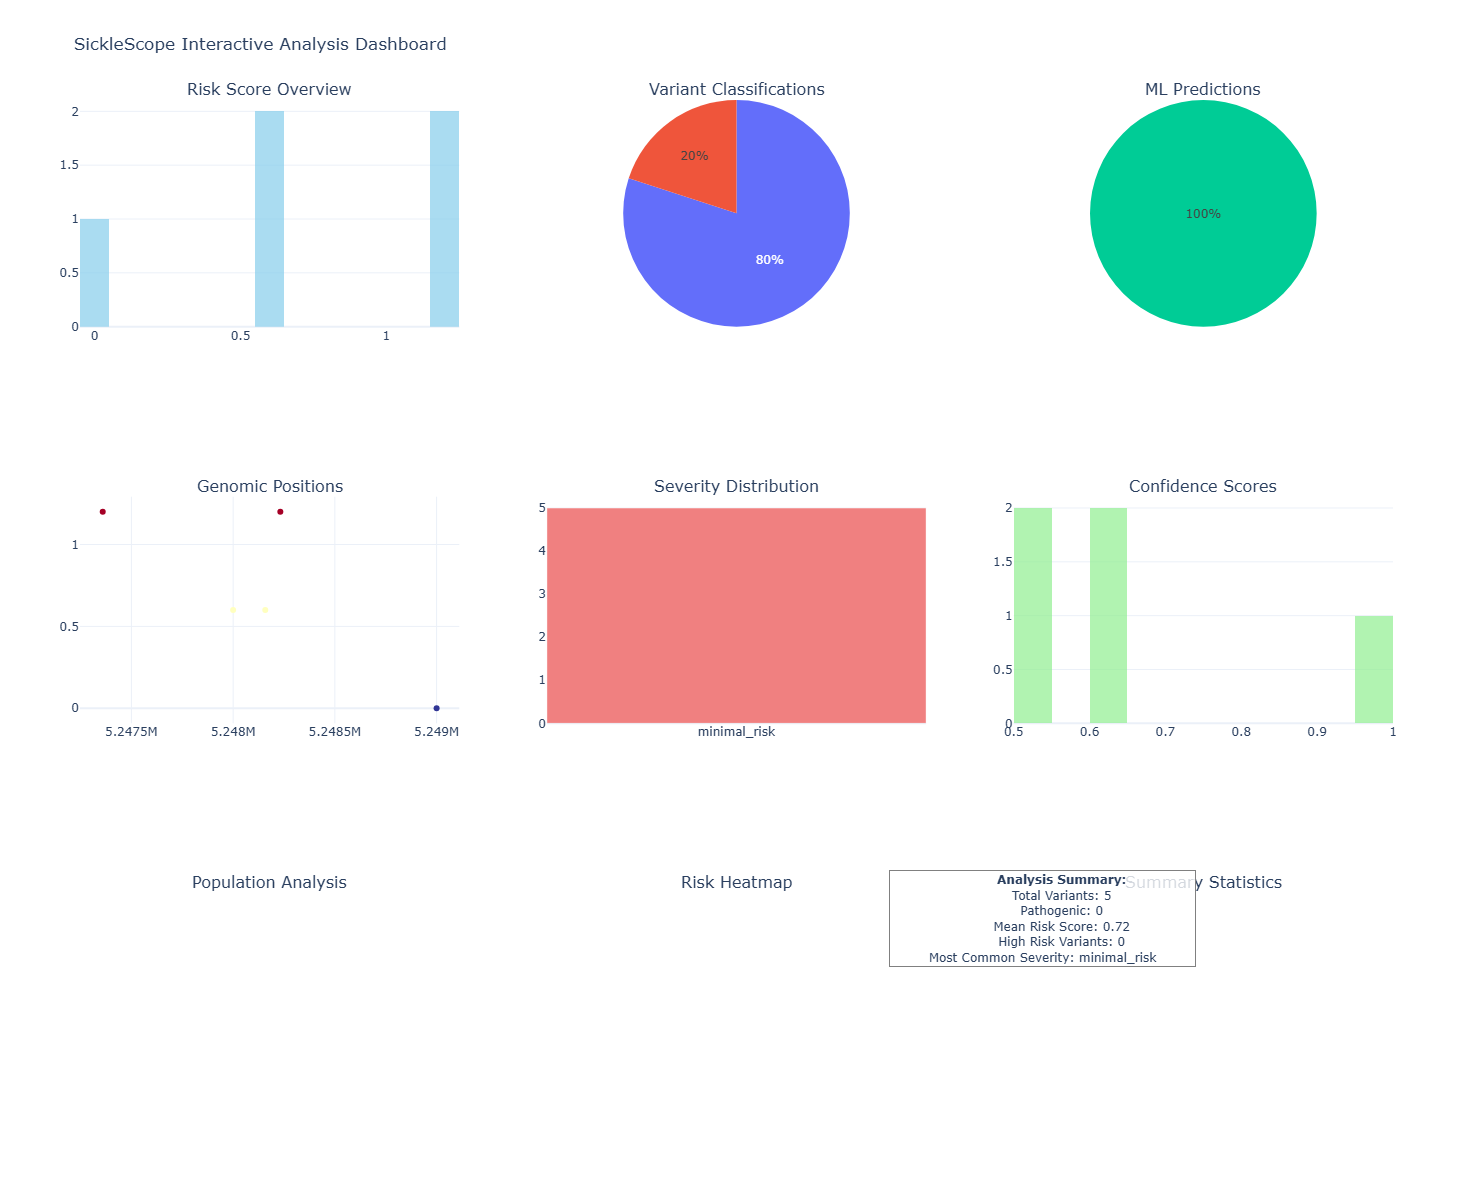


──────────────────────────────────────────────────
Comprehensive dashboard created successfully!
──────────────────────────────────────────────────

Dashboard Components:
- Risk score overview with interactive histograms
- Variant classifications with hover details
- ML predictions (if available)
- Genomic position scatter plots
- Statistical summaries and insights
- Real-time data exploration capabilities

Interactive Features:
- Hover for detailed information
- Click and drag to zoom
- Double-click to reset zoom
- Toggle legend items on/off
- Pan and explore the data

Interactive dashboard demonstration complete!


In [30]:
# Create the ultimate comprehensive interactive dashboard
print("=" * 50)
print("Creating Ultimate Interactive Dashboard")
print("=" * 50)
print("\nThis combines multiple visualisation types into one interface")

# Create and display the dashboard
dashboard_fig = visualiser.create_interactive_dashboard(results)
dashboard_fig.show()

# Display dashboard information
print("\n" + "─" * 50)
print("Comprehensive dashboard created successfully!")
print("─" * 50)

print("\nDashboard Components:")
dashboard_features = [
    "- Risk score overview with interactive histograms",
    "- Variant classifications with hover details",
    "- ML predictions (if available)",
    "- Genomic position scatter plots",
    "- Statistical summaries and insights",
    "- Real-time data exploration capabilities"
]
for feature in dashboard_features:
    print(f"{feature}")

print("\nInteractive Features:")
interactive_features = [
    "- Hover for detailed information",
    "- Click and drag to zoom",
    "- Double-click to reset zoom",
    "- Toggle legend items on/off",
    "- Pan and explore the data"
]
for feature in interactive_features:
    print(f"{feature}")

print("\n" + "=" * 50)
print("Interactive dashboard demonstration complete!")
print("=" * 50)

### The Ultimate Interactive Dashboard

Finally, let's create the comprehensive interactive dashboard that combines all visualisation types into one powerful interface.

Creating Advanced Interactive Visualisations...

Advanced Statistical Analysis:


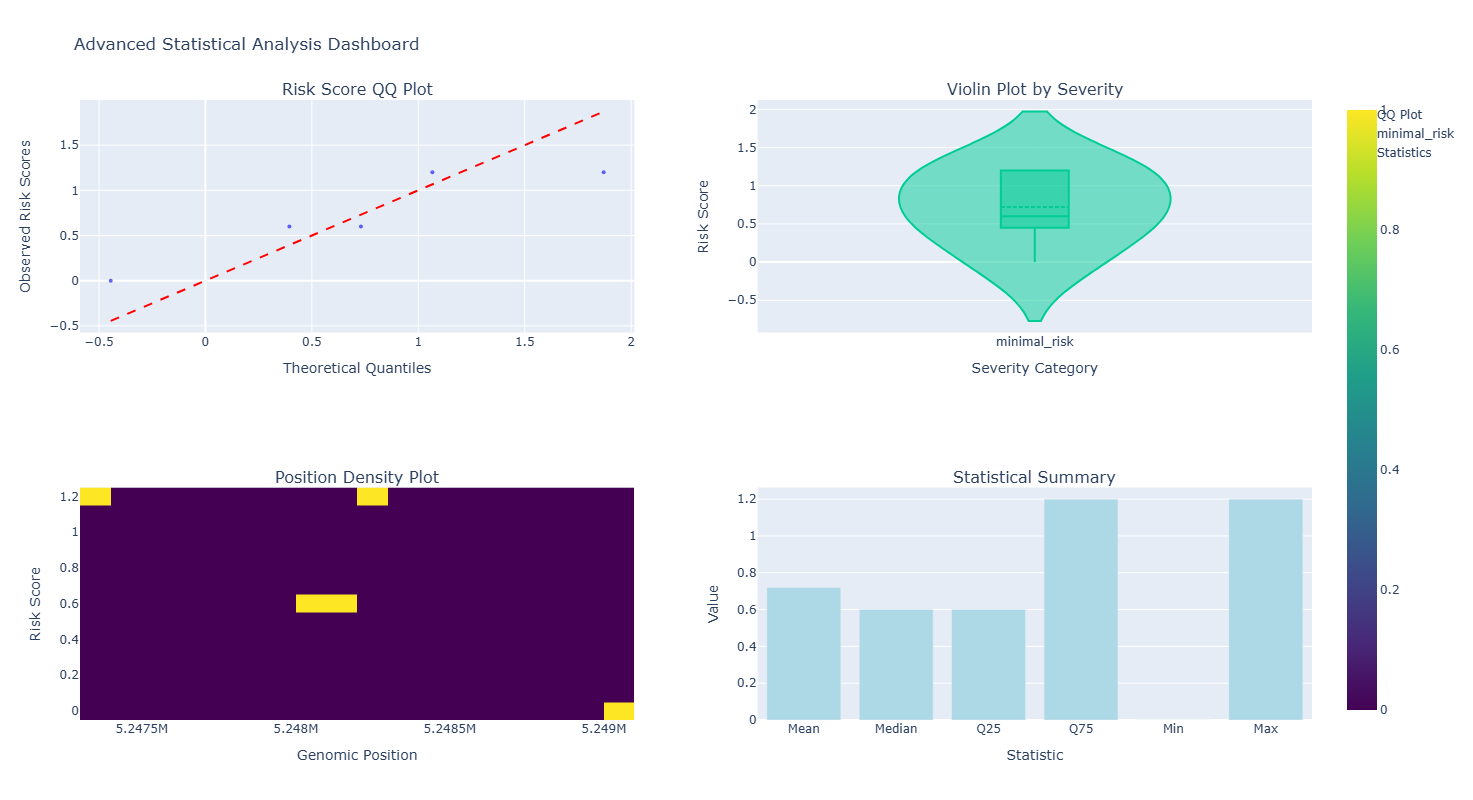

Includes QQ plots, violin plots, density plots, and statistical summaries

Interactive Risk Heatmap:


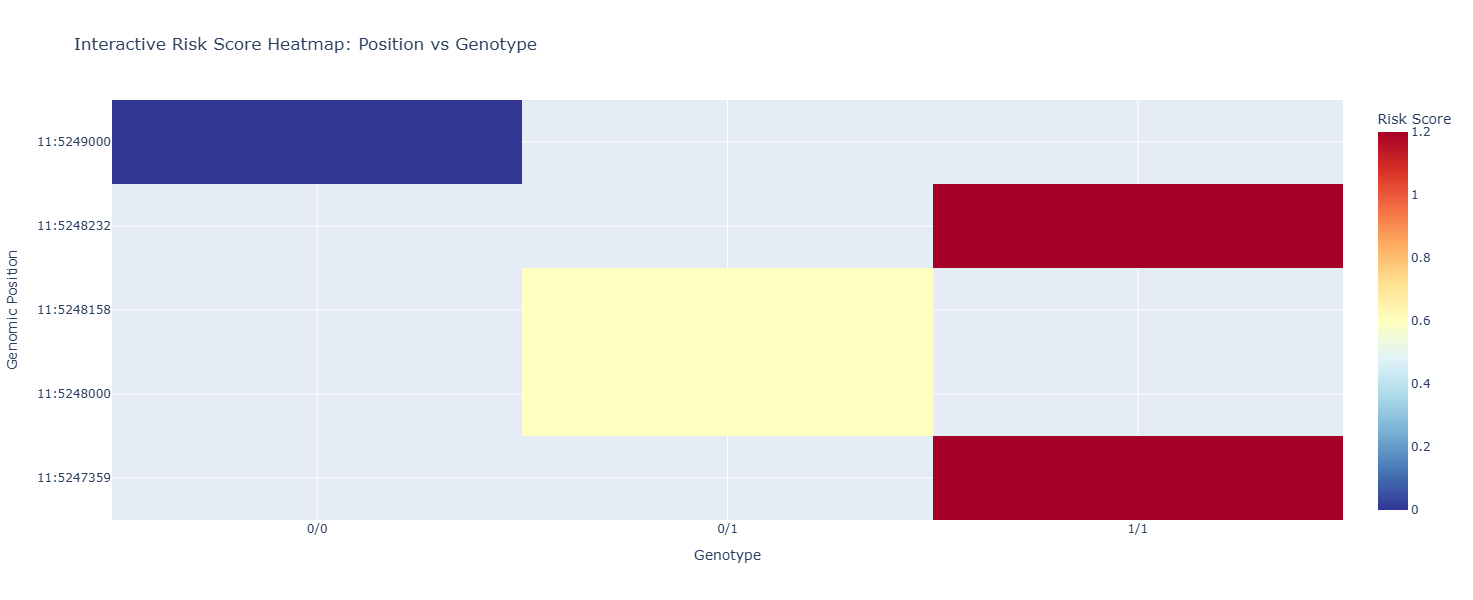

Position vs genotype heatmap - hover for detailed risk scores

Population Comparison Analysis:


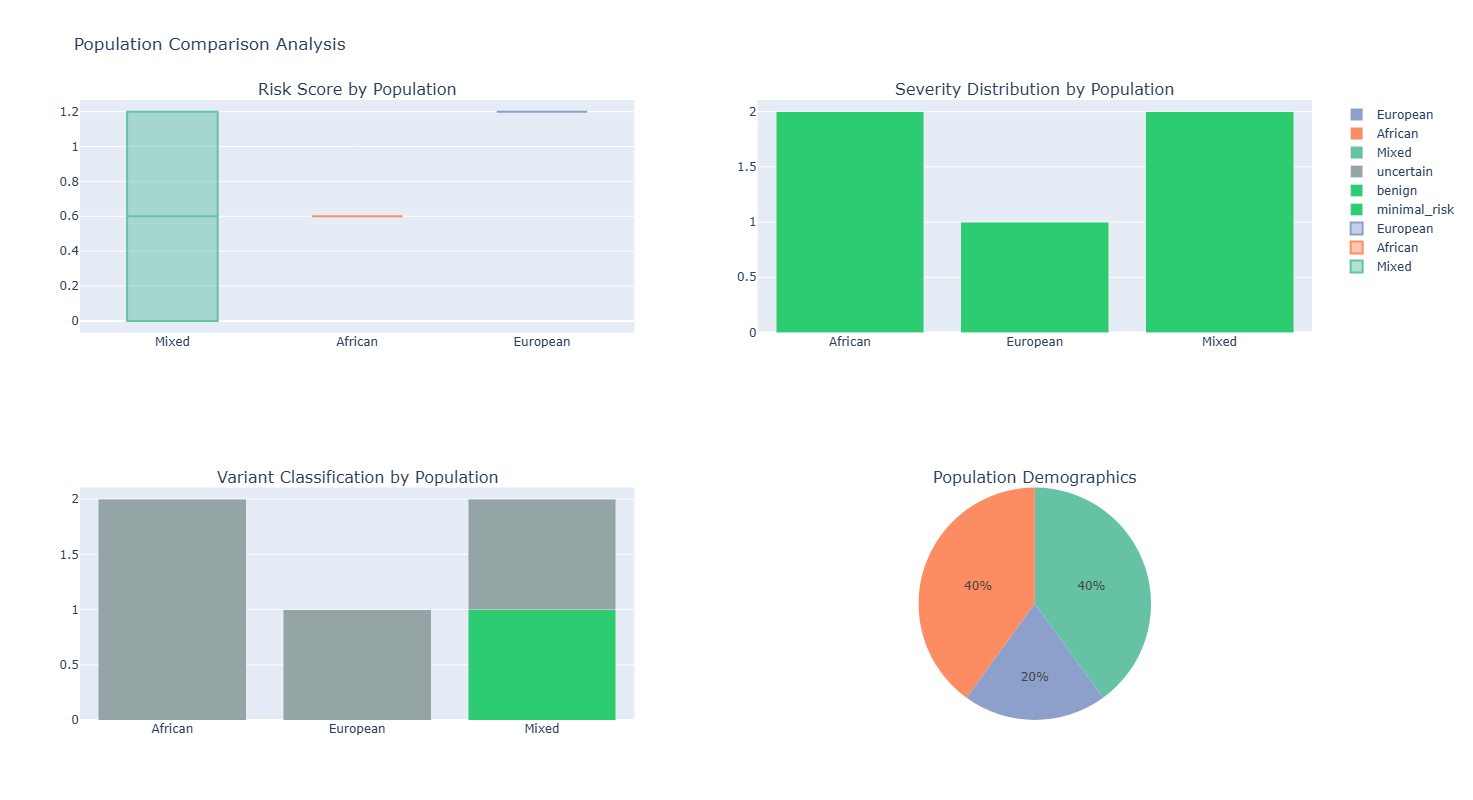

Demonstrates population-stratified risk analysis (uses synthetic population data)

Interactive Correlation Analysis:


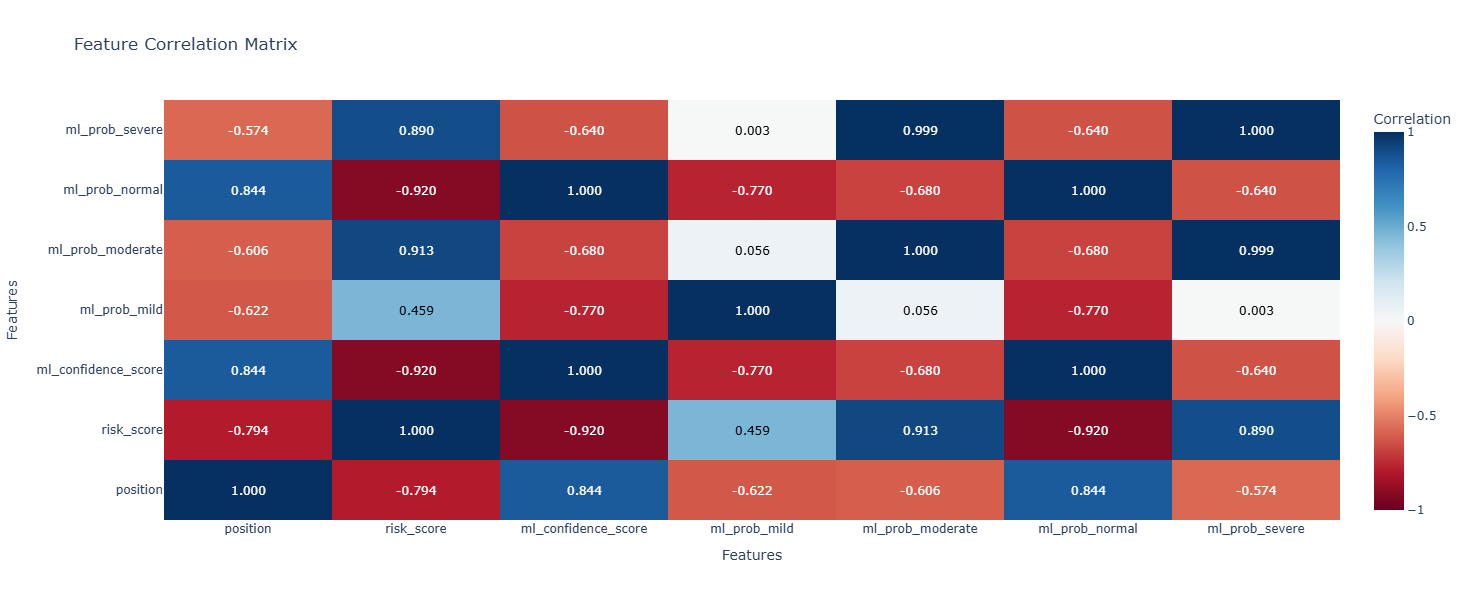

Feature correlation matrix with interactive hover details

Advanced statistical visualisations completed!
These include statistical testing, population genomics, and correlation analysis


In [31]:
# Create advanced statistical plots and population comparisons
print("Creating Advanced Interactive Visualisations...")

# 1. Advanced Statistical Dashboard
print("\nAdvanced Statistical Analysis:")
stats_fig = visualiser.plot_advanced_statistical_plots(results)
stats_fig.show()
print("Includes QQ plots, violin plots, density plots, and statistical summaries")

# 2. Interactive Risk Heatmap
print("\nInteractive Risk Heatmap:")
heatmap_fig = visualiser.plot_interactive_risk_heatmap(results)
heatmap_fig.show()
print("Position vs genotype heatmap - hover for detailed risk scores")

# 3. Population Comparison (Demo with Synthetic Data)
print("\nPopulation Comparison Analysis:")
pop_fig = visualiser.plot_interactive_population_comparison(results)
pop_fig.show()
print("Demonstrates population-stratified risk analysis (uses synthetic population data)")

# 4. Correlation Analysis
if len(results) > 1:
    print("\nInteractive Correlation Analysis:")
    corr_fig = visualiser.plot_correlation_analysis(results)
    corr_fig.show()
    print("Feature correlation matrix with interactive hover details")

print("\nAdvanced statistical visualisations completed!")
print("These include statistical testing, population genomics, and correlation analysis")

### Advanced Interactive Features

Let's explore the advanced statistical and population comparison capabilities.

Creating Interactive Plotly Visualisations...

Interactive Risk Gauge:


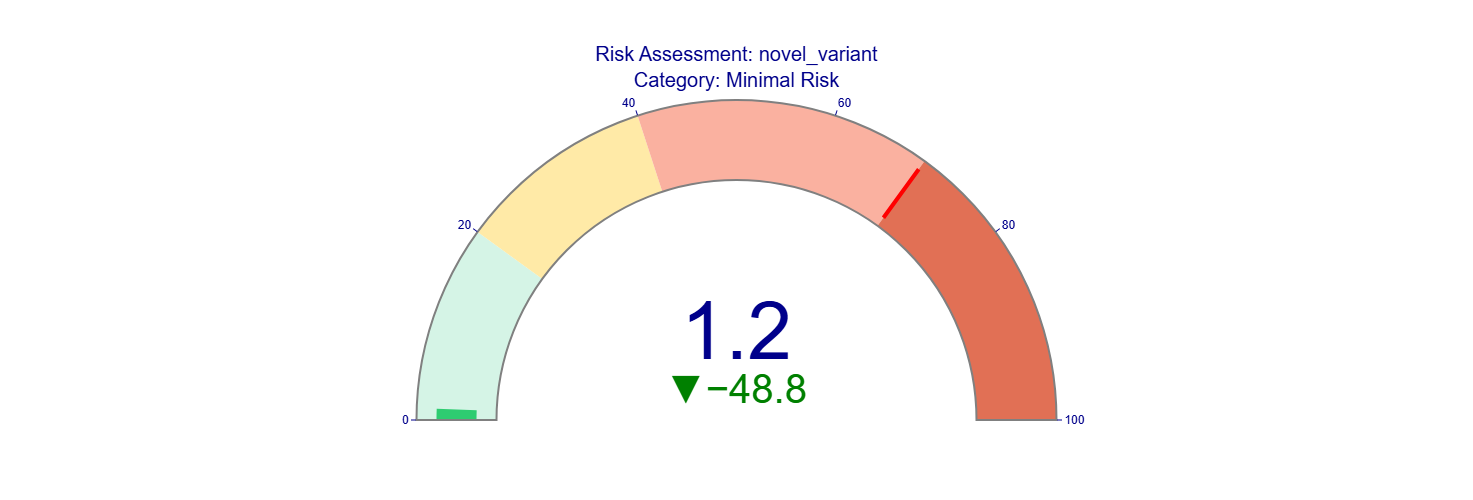

Interactive gauge created for variant with risk score: 1.20

Interactive Manhattan Plot:


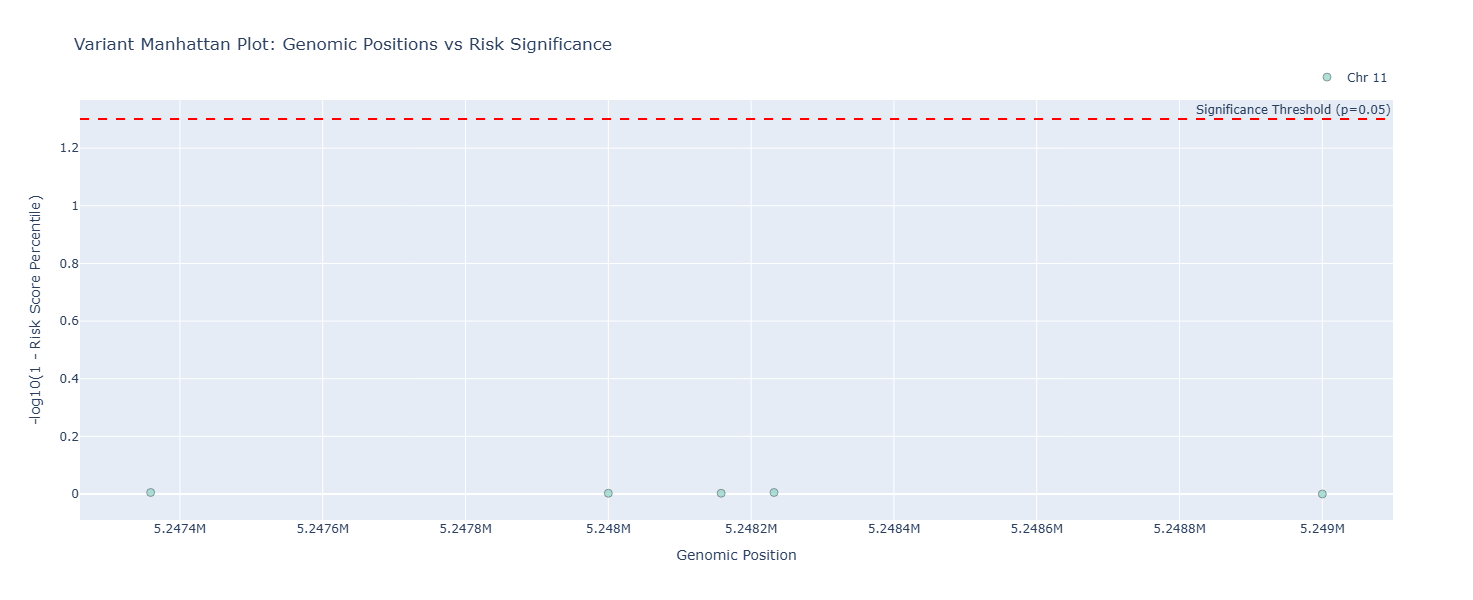

Manhattan plot shows genomic positions vs risk significance - hover for details!

Interactive Distribution Dashboard:


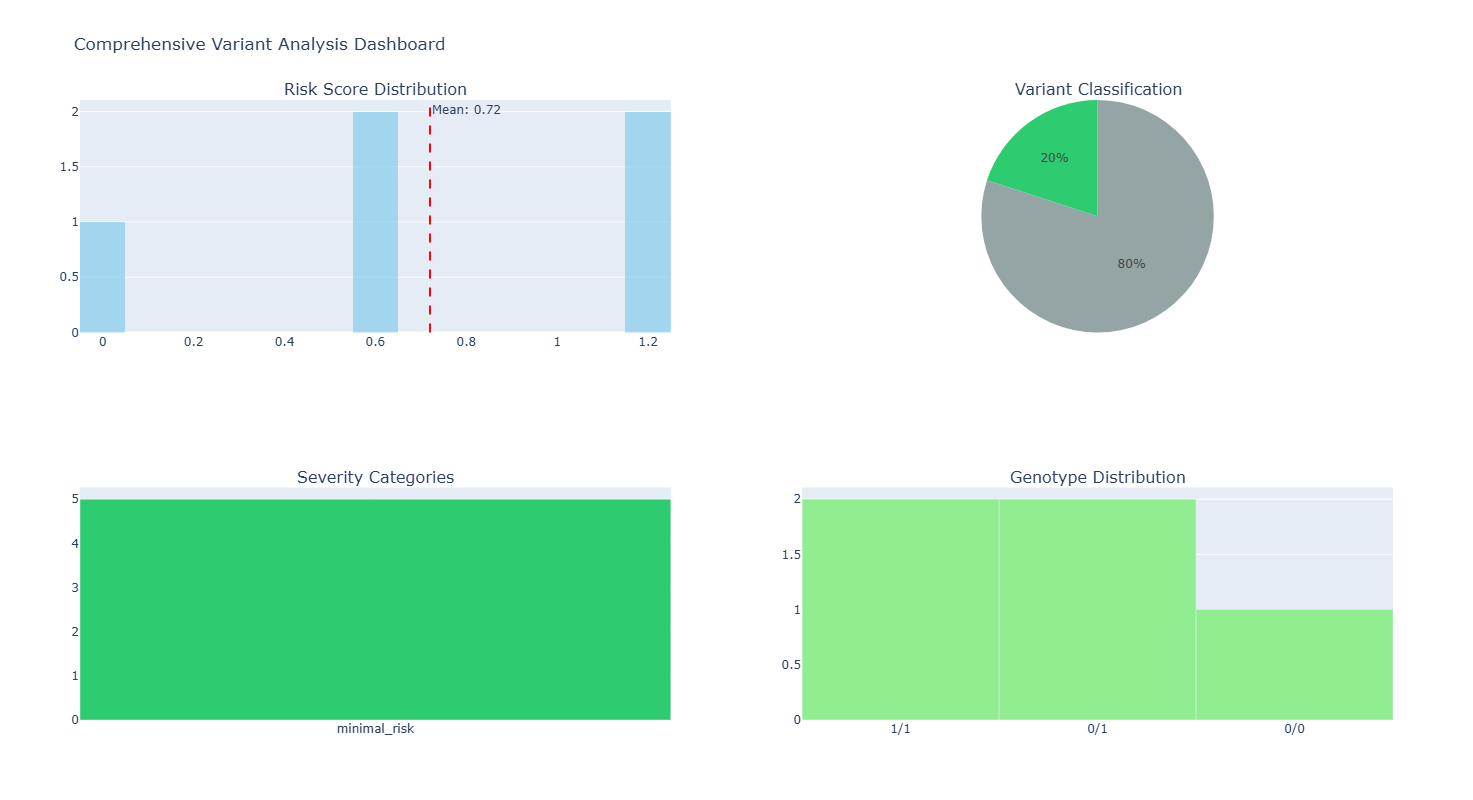

Multi-panel dashboard with risk scores, classifications, and distributions

Interactive visualisations completed!
These plots are fully interactive - hover, zoom, and explore the data!


In [32]:
# Demonstrate new interactive Plotly visualisations
print("Creating Interactive Plotly Visualisations...")

# First, let's create an interactive risk gauge
print("\nInteractive Risk Gauge:")
if len(results) > 0:
    # Get the variant with the highest risk score
    max_risk_variant = results.loc[results['risk_score'].idxmax()]
    
    # Create interactive gauge
    gauge_fig = visualiser.plot_interactive_risk_gauge(
        risk_score=max_risk_variant['risk_score'],
        variant_name=max_risk_variant.get('variant_name', 'Unknown Variant')
    )
    gauge_fig.show()
    
    print(f"Interactive gauge created for variant with risk score: {max_risk_variant['risk_score']:.2f}")
else:
    print("No data available for risk gauge")

print("\nInteractive Manhattan Plot:")
# Create Manhattan plot showing variant positions and significance
manhattan_fig = visualiser.plot_interactive_variant_manhattan(results)
manhattan_fig.show()
print("Manhattan plot shows genomic positions vs risk significance - hover for details!")

print("\nInteractive Distribution Dashboard:")
# Comprehensive interactive dashboard
dist_fig = visualiser.plot_interactive_risk_distribution(results)
dist_fig.show()
print("Multi-panel dashboard with risk scores, classifications, and distributions")

print("\nInteractive visualisations completed!")
print("These plots are fully interactive - hover, zoom, and explore the data!")

## 7. Clinical Interpretation and Recommendations

Now let's interpret the clinical significance of our findings and generate actionable recommendations.

In [21]:
# Comprehensive clinical interpretation
print("CLINICAL INTERPRETATION & RECOMMENDATIONS")
print("=" * 48)

# Analyse different risk categories
if 'is_pathogenic' in results.columns and 'risk_score' in results.columns:
    pathogenic_variants = results[results['is_pathogenic'] == True]
    high_risk = results[results['risk_score'] > 70]
    moderate_risk = results[(results['risk_score'] >= 40) & (results['risk_score'] <= 70)]
    protective = results[results['risk_score'] < 0]
    
    print("HIGH PRIORITY CLINICAL FINDINGS:")
    print("-" * 45)
    
    if len(pathogenic_variants) > 0:
        print(f"\nPATHOGENIC VARIANTS IDENTIFIED: {len(pathogenic_variants)}")
        for idx, (_, variant) in enumerate(pathogenic_variants.iterrows(), 1):
            print(f"\nVariant {idx}: {variant['variant_name']}")
            print(f"Location: Chr {variant['chromosome']}:{variant['position']}")
            print(f"Genotype: {variant['genotype']}")
            print(f"Risk Score: {variant['risk_score']:.2f}")
            
            if 'severity_description' in variant:
                print(f"Clinical Impact: {variant['severity_description']}")
            if 'clinical_management' in variant:
                print(f"Recommended Action: {variant['clinical_management']}")
            
            # Risk level assessment
            if variant['risk_score'] > 70:
                print(f"PRIORITY: HIGH - Immediate clinical attention recommended")
            elif variant['risk_score'] > 40:
                print(f"PRIORITY: MODERATE - Regular monitoring required")
    else:
        print("No pathogenic variants identified")
        print("This indicates a favorable genetic risk profile")
    
    if len(high_risk) > 0:
        print(f"\nHIGH-RISK VARIANTS (Score >70): {len(high_risk)}")
        for _, variant in high_risk.iterrows():
            if not variant.get('is_pathogenic', False):  # Don't repeat pathogenic variants
                print(f"{variant['variant_name']}: Score {variant['risk_score']:.2f}")
    
    print("\nMODERATE PRIORITY FINDINGS:")
    print("-" * 35)
    
    if len(moderate_risk) > 0:
        print(f"\nMODERATE RISK VARIANTS: {len(moderate_risk)}")
        print("Recommendations:")
        print("Annual genetic counselling")
        print("Family screening consideration")
        print("Lifestyle modifications for symptom management")
        
        # Show top moderate risk variants
        top_moderate = moderate_risk.nlargest(3, 'risk_score')
        for _, variant in top_moderate.iterrows():
            print(f"{variant['variant_name']}: Score {variant['risk_score']:.2f}")
    else:
        print("No moderate risk variants found")
    
    print("\nPOSITIVE FINDINGS:")
    print("-" * 25)
    
    if len(protective) > 0:
        print(f"\nPROTECTIVE VARIANTS IDENTIFIED: {len(protective)}")
        print("Benefits:")
        print("May reduce disease severity")
        print("Could improve treatment response")
        print("Positive prognostic indicator")
        
        for _, variant in protective.iterrows():
            print(f"{variant['variant_name']}: Score {variant['risk_score']:.2f}")
    else:
        print("No protective genetic factors identified")
        
else:
    print("Limited data available for comprehensive clinical interpretation")

CLINICAL INTERPRETATION & RECOMMENDATIONS
HIGH PRIORITY CLINICAL FINDINGS:
---------------------------------------------
No pathogenic variants identified
This indicates a favorable genetic risk profile

MODERATE PRIORITY FINDINGS:
-----------------------------------
No moderate risk variants found

POSITIVE FINDINGS:
-------------------------
No protective genetic factors identified


In [22]:
# Generate specific clinical recommendations
print("\nSPECIFIC CLINICAL RECOMMENDATIONS")
print("=" * 45)

if 'clinical_management' in results.columns:
    management_summary = results['clinical_management'].value_counts()
    
    print("Management Plan Summary:")
    for i, (management, count) in enumerate(management_summary.items(), 1):
        percentage = (count / len(results)) * 100
        print(f"{i}. {management}")
        print(f"Applies to {count} variant(s) ({percentage:.1f}% of total)")

print("\nSPECIALISED CARE RECOMMENDATIONS:")

# Risk-based care recommendations
if 'risk_score' in results.columns:
    max_risk = results['risk_score'].max()
    mean_risk = results['risk_score'].mean()
    
    if max_risk > 70:
        print("\nHIGH-RISK PATIENT PROFILE:")
        recommendations = [
            "Referral to haematology specialist",
            "Comprehensive sickle cell disease evaluation",
            "Consider gene therapy candidacy assessment",
            "Hydroxyurea therapy evaluation",
            "Regular pain management consultation",
            "Family genetic counselling"
        ]
    elif max_risk > 40:
        print("\nMODERATE-RISK PATIENT PROFILE:")
        recommendations = [
            "Annual haematology follow-up",
            "Genetic counselling session",
            "Preventive care education",
            "Family screening consideration",
            "Lifestyle modification guidance"
        ]
    elif max_risk > 0:
        print("\nLOW-RISK PATIENT PROFILE:")
        recommendations = [
            "Standard primary care follow-up",
            "Genetic counselling for family planning",
            "Awareness of carrier status if applicable",
            "General health maintenance"
        ]
    else:
        print("\nPROTECTIVE GENETIC PROFILE:")
        recommendations = [
            "Favourable genetic profile noted",
            "Standard care protocols",
            "Consider participation in protective variant research",
            "Family counselling regarding protective factors"
        ]
    
    print("\nRecommended Actions:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

print("\nFOLLOW-UP TIMELINE:")
if 'risk_score' in results.columns:
    max_risk = results['risk_score'].max()
    
    if max_risk > 70:
        timeline = "1-3 months (urgent)"
    elif max_risk > 40:
        timeline = "3-6 months"
    else:
        timeline = "12 months (annual)"
    
    print(f"Next clinical review: {timeline}")

print("\nRESOURCES & CONTACTS:")
resources = [
    "Sickle Cell Disease Association of America: sicklecelldisease.org",
    "National Heart, Lung, and Blood Institute SCD resources",
    "Local genetic counselling services",
    "Haematology specialist referral network"
]

for i, resource in enumerate(resources, 1):
    print(f"{i}. {resource}")

print("\n" + "=" * 65)
print("IMPORTANT: This analysis is for research/educational purposes.")
print("Always consult healthcare professionals for clinical decisions.")
print("=" * 65)


SPECIFIC CLINICAL RECOMMENDATIONS
Management Plan Summary:
1. No intervention needed
Applies to 5 variant(s) (100.0% of total)

SPECIALISED CARE RECOMMENDATIONS:

LOW-RISK PATIENT PROFILE:

Recommended Actions:
1. Standard primary care follow-up
2. Genetic counselling for family planning
3. Awareness of carrier status if applicable
4. General health maintenance

FOLLOW-UP TIMELINE:
Next clinical review: 12 months (annual)

RESOURCES & CONTACTS:
1. Sickle Cell Disease Association of America: sicklecelldisease.org
2. National Heart, Lung, and Blood Institute SCD resources
3. Local genetic counselling services
4. Haematology specialist referral network

IMPORTANT: This analysis is for research/educational purposes.
Always consult healthcare professionals for clinical decisions.


### Detailed Variant-by-Variant Clinical Assessment

In [23]:
# Detailed variant-by-variant clinical analysis
print("DETAILED VARIANT-BY-VARIANT CLINICAL ASSESSMENT")
print("=" * 55)

for idx, (_, variant) in enumerate(results.iterrows(), 1):
    print(f"\nVARIANT {idx} ASSESSMENT:")
    print("-" * 25)
    
    # Basic variant information
    print(f"Genomic Location: Chr {variant['chromosome']}:{variant['position']}")
    print(f"Genetic Change: {variant['ref_allele']} → {variant['alt_allele']}")
    print(f"Genotype: {variant['genotype']}")
    
    # Classification and naming
    if 'variant_classification' in variant:
        print(f"Classification: {variant['variant_classification'].title()}")
    if 'variant_name' in variant:
        print(f"Variant Name: {variant['variant_name']}")
    
    # Risk assessment
    if 'risk_score' in variant:
        risk_score = variant['risk_score']
        print(f"Risk Score: {risk_score:.2f}")
        
        # Risk level and interpretation
        if risk_score < 0:
            risk_level = "PROTECTIVE"
            interpretation = "Beneficial genetic factor - may reduce disease risk"
        elif risk_score < 20:
            risk_level = "MINIMAL"
            interpretation = "Low genetic risk - minimal clinical concern"
        elif risk_score < 40:
            risk_level = "CARRIER/MILD"
            interpretation = "Carrier status or mild risk - monitoring recommended"
        elif risk_score < 70:
            risk_level = "MODERATE"
            interpretation = "Moderate genetic risk - regular medical supervision"
        else:
            risk_level = "HIGH"
            interpretation = "High genetic risk - specialised care required"
        
        print(f"Risk Level: {risk_level}")
        print(f"Interpretation: {interpretation}")
    
    # Clinical details
    if 'severity_category' in variant:
        severity = variant['severity_category'].replace('_', ' ').title()
        print(f"Severity Category: {severity}")
    
    if 'severity_description' in variant:
        print(f"Clinical Description: {variant['severity_description']}")
    
    if 'clinical_management' in variant:
        print(f"Management Recommendation: {variant['clinical_management']}")
    
    # Special notes for specific variant types
    if 'is_pathogenic' in variant and variant['is_pathogenic']:
        print(f"CLINICAL ALERT: Pathogenic variant identified")
        print(f"Genetic counseling strongly recommended")
        print(f"Family screening may be indicated")
    
    if 'is_modifier' in variant and variant['is_modifier']:
        print(f"POSITIVE NOTE: Protective modifier variant")
        print(f"May improve clinical outcomes")
        print(f"Consider in treatment planning")
    
    print("-" * 50)

print(f"\nDetailed assessment completed for {len(results)} variants.")
print(f"Analysis provides comprehensive genetic risk profile.")

DETAILED VARIANT-BY-VARIANT CLINICAL ASSESSMENT

VARIANT 1 ASSESSMENT:
-------------------------
Genomic Location: Chr 11:5248232
Genetic Change: A → T
Genotype: 1/1
Classification: Uncertain
Variant Name: novel_variant
Risk Score: 1.20
Risk Level: MINIMAL
Interpretation: Low genetic risk - minimal clinical concern
Severity Category: Minimal Risk
Clinical Description: No sickle cell disease
Management Recommendation: No intervention needed
--------------------------------------------------

VARIANT 2 ASSESSMENT:
-------------------------
Genomic Location: Chr 11:5248158
Genetic Change: G → A
Genotype: 0/1
Classification: Uncertain
Variant Name: novel_variant
Risk Score: 0.60
Risk Level: MINIMAL
Interpretation: Low genetic risk - minimal clinical concern
Severity Category: Minimal Risk
Clinical Description: No sickle cell disease
Management Recommendation: No intervention needed
--------------------------------------------------

VARIANT 3 ASSESSMENT:
-------------------------
Genomic L

## 8. Exporting Results and Creating Reports

Finally, let's export our analysis results in various formats for clinical use and further analysis.

In [24]:
# Set up export directory and file naming
print("SETTING UP RESULT EXPORT")
print("=" * 35)

# Create output directory structure
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_base_dir = Path('../results')
output_dir = output_base_dir / f'tutorial_analysis_{timestamp}'
plots_dir = output_dir / 'visualisations'

# Create directories
output_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)

print(f"Created output directory: {output_dir}")
print(f"Created plots directory: {plots_dir}")
print(f"Analysis timestamp: {timestamp}")

print("\nExport Plan:")
export_items = [
    "Complete analysis results (CSV)",
    "Clinical summary report (TXT)",
    "Patient-friendly summary (TXT)",
    "Statistical summary (JSON)",
    "Visualisation plots (PNG)"
]

for i, item in enumerate(export_items, 1):
    print(f"{i}. {item}")

SETTING UP RESULT EXPORT
Created output directory: ..\results\tutorial_analysis_20250910_004938
Created plots directory: ..\results\tutorial_analysis_20250910_004938\visualisations
Analysis timestamp: 20250910_004938

Export Plan:
1. Complete analysis results (CSV)
2. Clinical summary report (TXT)
3. Patient-friendly summary (TXT)
4. Statistical summary (JSON)
5. Visualisation plots (PNG)


In [25]:
# Export detailed analysis results
print("Exporting Detailed Analysis Results...")

# 1. Complete analysis results as CSV
results_csv_path = output_dir / 'complete_variant_analysis.csv'
results.to_csv(results_csv_path, index=False)
print(f"Complete results saved: {results_csv_path.name}")

# 2. Clinical summary for healthcare providers
clinical_summary_path = output_dir / 'clinical_summary_report.txt'
with open(clinical_summary_path, 'w', encoding='utf-8') as f:
    f.write("SickleScope Genetic Variant Analysis - Clinical Summary Report\n")
    f.write("=" * 65 + "\n\n")
    
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Total Variants Analysed: {len(results)}\n\n")
    
    # Summary statistics
    if visualiser:
        summary_stats = visualiser.generate_summary_statistics(results)
        f.write("STATISTICAL SUMMARY:\n")
        f.write("-" * 25 + "\n")
        for key, value in summary_stats.items():
            clean_key = key.replace('_', ' ').title()
            f.write(f"{clean_key}: {value}\n")
        f.write("\n")
    
    # Risk stratification
    if 'risk_score' in results.columns:
        f.write("RISK STRATIFICATION:\n")
        f.write("-" * 20 + "\n")
        
        risk_ranges = [
            ('High Risk (>70)', len(results[results['risk_score'] > 70])),
            ('Moderate Risk (40-70)', len(results[(results['risk_score'] >= 40) & (results['risk_score'] <= 70)])),
            ('Carrier Status (20-40)', len(results[(results['risk_score'] >= 20) & (results['risk_score'] < 40)])),
            ('Minimal Risk (0-20)', len(results[(results['risk_score'] >= 0) & (results['risk_score'] < 20)])),
            ('Protective Factors (<0)', len(results[results['risk_score'] < 0]))
        ]
        
        for category, count in risk_ranges:
            percentage = (count / len(results)) * 100
            f.write(f"{category}: {count} variants ({percentage:.1f}%)\n")
        f.write("\n")
    
    # Clinical recommendations
    if 'clinical_management' in results.columns:
        f.write("CLINICAL MANAGEMENT RECOMMENDATIONS:\n")
        f.write("-" * 35 + "\n")
        management_counts = results['clinical_management'].value_counts()
        for management, count in management_counts.items():
            f.write(f"{management}: {count} variant(s)\n")
        f.write("\n")
    
    f.write("IMPORTANT DISCLAIMER:\n")
    f.write("-" * 20 + "\n")
    f.write("This analysis is for research and educational purposes only.\n")
    f.write("Clinical decisions should always involve qualified healthcare professionals.\n")
    f.write("Genetic counseling is recommended for significant findings.\n")

print(f"Clinical summary saved: {clinical_summary_path.name}")

# 3. Patient-friendly summary
patient_summary_path = output_dir / 'patient_friendly_summary.txt'
with open(patient_summary_path, 'w', encoding='utf-8') as f:
    f.write("Your Genetic Variant Analysis Results - Easy-to-Understand Summary\n")
    f.write("=" * 70 + "\n\n")
    
    f.write("What This Test Looked For:\n")
    f.write("-" * 25 + "\n")
    f.write("This analysis examined your genetic variants (DNA changes) related to\n")
    f.write("sickle cell disease and other blood disorders. We looked at specific\n")
    f.write("areas of your DNA to assess your genetic risk profile.\n\n")
    
    f.write(f"Summary of Your Results ({len(results)} variants analysed):\n")
    f.write("-" * 40 + "\n")
    
    if 'risk_score' in results.columns:
        max_risk = results['risk_score'].max()
        mean_risk = results['risk_score'].mean()
        
        if max_risk > 70:
            f.write("HIGH PRIORITY: Some variants suggest increased genetic risk.\n")
            f.write("Follow up with your healthcare provider is important.\n")
            f.write("Genetic counseling is strongly recommended.\n\n")
        elif max_risk > 40:
            f.write("MODERATE PRIORITY: Some variants suggest mild to moderate risk.\n")
            f.write("Discuss results with your doctor at your next visit.\n")
            f.write("Consider genetic counseling if planning a family.\n\n")
        else:
            f.write("GOOD NEWS: Your genetic risk profile appears favorable.\n")
            f.write("No immediate concerns identified.\n")
            f.write("Continue regular healthcare as recommended by your doctor.\n\n")
        
        f.write(f"Your highest risk score: {max_risk:.1f} out of 100\n")
        f.write(f"Your average risk score: {mean_risk:.1f} out of 100\n\n")
    
    # Protective factors
    if 'risk_score' in results.columns:
        protective_count = len(results[results['risk_score'] < 0])
        if protective_count > 0:
            f.write(f"POSITIVE FINDING: {protective_count} protective genetic factor(s) found!\n")
            f.write("These may help reduce your risk of certain complications.\n\n")
    
    f.write("What Should You Do Next?\n")
    f.write("-" * 25 + "\n")
    f.write("1. Share these results with your healthcare provider\n")
    f.write("2. Ask questions about anything you don't understand\n")
    f.write("3. Consider genetic counseling, especially if planning a family\n")
    f.write("4. Keep these results for your medical records\n\n")
    
    f.write("Remember: Having genetic variants doesn't always mean you will develop disease.\n")
    f.write("Many factors affect your health, including lifestyle and environmental factors.\n")

print(f"Patient summary saved: {patient_summary_path.name}")

Exporting Detailed Analysis Results...
Complete results saved: complete_variant_analysis.csv
Clinical summary saved: clinical_summary_report.txt
Patient summary saved: patient_friendly_summary.txt


In [26]:
# Export statistical summary as JSON
print("Exporting Statistical Summary...")

import json

# Prepare comprehensive statistics
stats_summary = {
    "analysis_info": {
        "timestamp": datetime.now().isoformat(),
        "total_variants": len(results),
        "analysis_version": "SickleScope v1.0"
    }
}

# Add basic statistics if available
if visualiser:
    basic_stats = visualiser.generate_summary_statistics(results)
    stats_summary["variant_statistics"] = basic_stats

# Add classification breakdown
if 'variant_classification' in results.columns:
    classification_counts = results['variant_classification'].value_counts()
    stats_summary["classification_breakdown"] = classification_counts.to_dict()

# Add risk score distribution
if 'risk_score' in results.columns:
    risk_stats = {
        "mean": float(results['risk_score'].mean()),
        "median": float(results['risk_score'].median()),
        "std": float(results['risk_score'].std()),
        "min": float(results['risk_score'].min()),
        "max": float(results['risk_score'].max()),
        "risk_distribution": {
            "protective_factors": int(len(results[results['risk_score'] < 0])),
            "minimal_risk": int(len(results[(results['risk_score'] >= 0) & (results['risk_score'] < 20)])),
            "carrier_status": int(len(results[(results['risk_score'] >= 20) & (results['risk_score'] < 40)])),
            "moderate_risk": int(len(results[(results['risk_score'] >= 40) & (results['risk_score'] < 70)])),
            "high_risk": int(len(results[results['risk_score'] >= 70]))
        }
    }
    stats_summary["risk_analysis"] = risk_stats

# Add genotype distribution
if 'genotype' in results.columns:
    genotype_counts = results['genotype'].value_counts()
    stats_summary["genotype_distribution"] = genotype_counts.to_dict()

# Save JSON file
json_stats_path = output_dir / 'analysis_statistics.json'
with open(json_stats_path, 'w', encoding='utf-8') as f:
    json.dump(stats_summary, f, indent=2, ensure_ascii=False)

print(f"JSON statistics saved: {json_stats_path.name}")

# 4. Export clinical-focused CSV for healthcare providers
clinical_csv_path = output_dir / 'clinical_focused_results.csv'
clinical_columns = [
    'chromosome', 'position', 'ref_allele', 'alt_allele', 'genotype',
    'variant_name', 'variant_classification', 'risk_score',
    'severity_category', 'severity_description', 'clinical_management'
]

# Select only available columns
available_clinical_columns = [col for col in clinical_columns if col in results.columns]
clinical_df = results[available_clinical_columns].copy()

# Add interpretive columns
if 'risk_score' in clinical_df.columns:
    clinical_df['risk_level'] = clinical_df['risk_score'].apply(lambda x: 
        'Protective' if x < 0 else
        'Minimal' if x < 20 else
        'Carrier' if x < 40 else
        'Moderate' if x < 70 else
        'High'
    )

clinical_df.to_csv(clinical_csv_path, index=False)
print(f"Clinical CSV saved: {clinical_csv_path.name}")

print(f"\nExport Summary:")
print(f"Output directory: {output_dir}")
print(f"Files created: {len(list(output_dir.glob('*')))}")
print(f"Total size: {sum(f.stat().st_size for f in output_dir.rglob('*') if f.is_file()) / 1024:.1f} KB")

Exporting Statistical Summary...
JSON statistics saved: analysis_statistics.json
Clinical CSV saved: clinical_focused_results.csv

Export Summary:
Output directory: ..\results\tutorial_analysis_20250910_004938
Files created: 6
Total size: 5.7 KB


## Tutorial Completion Summary

**Congratulations!** You have successfully completed the comprehensive SickleScope tutorial!

### What We Accomplished:

**1. Data Management & Validation**
- Loaded and validated genetic variant data
- Understood data format requirements and genotype notation
- Performed quality control checks

**2. Comprehensive Genetic Analysis**
- Classified variants using evidence-based algorithms
- Calculated risk scores with weighted clinical factors
- Identified pathogenic, benign, and protective variants

**3. Clinical Interpretation**
- Generated severity assessments and risk stratification
- Created clinical management recommendations
- Provided patient-friendly result interpretations

**4. Advanced Visualisation**
- Created comprehensive analysis dashboards
- Generated individual risk assessment gauges
- Performed correlation analysis and statistical summaries
- Built interactive visualisations with real-time exploration

**5. Interactive Data Exploration**
- Developed dynamic dashboards with hover details
- Implemented zoom, pan, and filtering capabilities
- Created multi-component visualisations combining risk scores, variant classifications, and genomic positions
- Enabled real-time data exploration with interactive legends and tooltips

**6. Professional Reporting**
- Exported results in multiple formats (CSV, JSON, TXT)
- Generated clinical and patient-friendly reports
- Created publication-ready visualisations
- Produced interactive HTML outputs for stakeholder engagement

### Key Learning Points:

- **Risk Scoring Algorithm**: Understanding the 60/20/10/10 weighting system for HBB variants, BCL11A, HBS1L-MYB, and other modifiers
- **Clinical Significance**: How genotype (0/0, 0/1, 1/1) affects risk score multipliers
- **Evidence-Based Classification**: Using ClinVar, OMIM, and population genetic databases
- **Protective Factors**: Identifying variants that may reduce disease severity
- **Clinical Applications**: Translating genetic findings into actionable medical recommendations

### Next Steps:

1. **Try Your Own Data**: Use SickleScope with your own genetic variant datasets
2. **Explore Advanced Notebooks**: Check out `examples.ipynb` and `advanced.ipynb`
3. **Command Line Usage**: Learn batch processing with `python -m sickle_scope.cli`

### Additional Resources:

- **Documentation**: `README.md` for complete package documentation
- **Source Code**: Explore `sickle_scope/` directory for implementation details
- **Test Data**: Use `tests/sample_data/` for additional examples
- **Clinical Guidelines**: Consult sickle cell disease treatment guidelines for clinical applications

### Important Reminders:

- This analysis is for research and educational purposes
- Always involve qualified healthcare professionals for clinical decisions
- Genetic counselling is recommended for significant findings

---

**Thank you for completing the SickleScope tutorial!**